#Clustering - Regroupement hiérarchique

##Introduction

L'algorithme de *regroupement hiérarchique* est un algorithme de clustering **supervisé**.</br>
On initialise l'algorithme en créant un cluster pour chaque point.</br>
Puis on regroupe les deux clusters les plus proches jusqu'a atteindre le nombre de clusters souhaités. On utilise pour cela la distance minimale, moyenne ou maximale entre les clusters.</br>

##Création des données
Pour commencer, nous allons créer les données que nous utiliserons pour la suite dans l'algorithme. L'idée est de créer des données d'initialisation et des données de test (pour évaluer l'efficacité de l'algorithme).</br>
L'explication de la création de ces données est réalisée dans le jupyter de l'algorithme *k-means*, ainsi nous ne nous étendrons pas sur la création de ces dernières.

In [0]:
# Importation des librairies
import numpy as np
import matplotlib.pyplot as plt

# Les paramètres importants
nbr_clusters=3
nbr_initialisation=30
nbr_evalutation=1000

# Les listes
init_points=[]
init_labels=[]
eval_points=[]
eval_labels=[]

donnees_initialisation=[[] for i in range(nbr_clusters)]

barycentres=[]
for i in range(nbr_clusters):
  barycentres.append(2*np.random.random_sample((2,))-1)

#barycentres=[np.array([0.8,0.8]),np.array([0.8,-0.8]),np.array([-0.8,-0.8]),np.array([-0.8,0.8])] 

# Création des données d'initialisation
for i in range(nbr_initialisation):
  indice=np.random.randint(0,nbr_clusters)
  point=barycentres[indice]+np.random.normal(scale=0.2,size=2) # Répartition normale autour d'un barycentre
  init_points.append(point)
  init_labels.append(indice)
  donnees_initialisation[indice].append(point)
 
# Création des données de test
for i in range(nbr_evalutation):
  indice=np.random.randint(0,nbr_clusters)
  point=barycentres[indice]+np.random.normal(scale=0.2,size=2) # Répartition normale autour d'un barycentre
  eval_points.append(point)
  eval_labels.append(indice)

Maintenant que nous avons créé les données, je vous propose de les visualiser

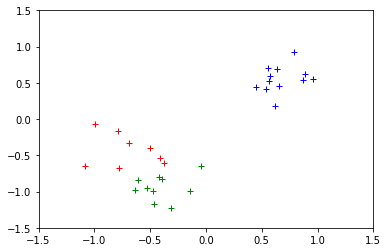

In [17]:
lim=1.5
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

# Définition des couleurs des clusters et des barycentres
couleurs=['r','g','b','y']
couleurs_barycentres=['#990000','#009900','#000099','#009999']

for i in range(nbr_initialisation):
  point=init_points[i]
  label=init_labels[i]
  plt.plot(point[0],point[1],color=couleurs[label],marker="+") # On affiche chaque point avec la couleur de son cluster
  
plt.show()

## Création de l'algorithme

### La distance entre clusters
Laissons cette base de donnée de coté et repartons avec quelque chose de plus simple. prenons dix points en une dimension, tirés aléatoirement entre 0 et 1000. 

[653, 801, 887, 347, 638, 449, 999, 377, 703, 225]

Nous attribuons un cluster a chaque point.</br>
Ici la distance entre deux éléments a et b c'est simplement |b-a|.</br>
La distance entre deux clusters est définie comme le *minimum* / la *moyenne* / le *maximum* entre les points des deux clusters pris deux a deux. </br>
On trouve les deux clusters les plus proches (distance la plus faible) et le tour est joué, il ne reste qu'a les fusionner.

In [18]:
def distance_element(e1, e2):
    """
    Fonction distance entre les éléments, qui retourne |b-a| dans cet exemple
    """
    if isinstance(e1, int):
      return abs(e1-e2)
    else:
      return np.linalg.norm(e1-e2)

def distance_cluster_fig(c1, c2, parametre_distance_cluster):
    """
    Fonction de distance entre des clusters
    """
    #distance minimale
    if parametre_distance_cluster == 'min':
        min_distance_cluster = distance_element(c1[0], c2[0])
        for element_c1 in c1:
            for element_c2 in c2:
                if distance_element(element_c1, element_c2) < min_distance_cluster:
                    min_distance_cluster = distance_element(element_c1, element_c2)
        return min_distance_cluster
      
    #distance maximale
    elif parametre_distance_cluster == 'max':
        max_distance_cluster = distance_element(c1[0], c2[0])
        for element_c1 in c1:
            for element_c2 in c2:
                if distance_element(element_c1, element_c2) > max_distance_cluster:
                    max_distance_cluster = distance_element(element_c1, element_c2)
        return max_distance_cluster
      
    #distance moyenne
    elif parametre_distance_cluster== 'mean':
        dist=0
        for element_c1 in c1:
            for element_c2 in c2:
                dist += distance_element(element_c1, element_c2)
        return dist/(len(c1)*len(c2))

# On crée les clusters de test
c1=[1,2,5]
c2=[4,6,9]
print("La distance minimale entre ces deux clusters est {} (distance entre 4 et 5)".format(distance_cluster_fig(c1,c2,"min")))
print("La distance maximale entre ces deux clusters est {} (distance entre 1 et 9)".format(distance_cluster_fig(c1,c2,"max")))
print("La distance moyenne entre ces deux clusters est {}".format(distance_cluster_fig(c1,c2,"mean")))

La distance minimale entre ces deux clusters est 1 (distance entre 4 et 5)
La distance maximale entre ces deux clusters est 8 (distance entre 1 et 9)
La distance moyenne entre ces deux clusters est 3.888888888888889


### Fusion des clusters
Maintenant que l'on connait les distances inter-cluster il suffit de trouver le minimum de ces distances. Nous travaillons avec une liste où ligne[k] est le numéro du cluster du point k.</br>
La fonction **fusion** passe d'une ligne à la suivante en réduisant de 1 le nombre de clusters.</br>
Pour cela on crée un *dictionnaire de clusters*.</br>
En testant pour tous les clusters, on trouve ainsi les clusters à fusionner (la distance est la plus petite).</br>
On les *fusionne* puis on crée la liste suivant des clusters des points. Il y aura donc une valeur de moins dans cette liste, car il y aura un cluster de moins.

In [19]:
import random as rd

liste_aleat=[rd.randint(0,100) for i in range (6)]
def fusion(ligne, i, liste_alea):
    c = {}
    for element in range(len(ligne)):
        if ligne[element] in c.keys():
            c[int(ligne[element])] = c[int(ligne[element])] + [liste_alea[element]]
        else:
            c[int(ligne[element])] = [liste_alea[element]]

    
    min = distance_cluster_fig(c[0], c[1], "mean")
    indices_min = (0, 1)
    for j in range(i-1):
        for l in range(j + 1, i):
            if distance_cluster_fig(c[j], c[l], "mean") <= min:
                min = distance_cluster_fig(c[j], c[l], "mean")
                indices_min = (j, l)
    j,l = indices_min
    print("")
    print ("il faut fusionner "+str(c[j])+" et "+str(c[l]))
    print ("cela correspond à "+ str(j)+ " et " + str(l))
    #on a assuré j<l 
    
    for element_ligne in range(len(ligne)):
        if ligne[element_ligne]==l: ligne[element_ligne]=j
        elif ligne[element_ligne]==i: ligne[element_ligne]=l
    print ("voici la ligne à l'étape suivante :")
    return ligne
  
fusion([0,1,2,3,4,5],5,liste_aleat)


il faut fusionner [47] et [49]
cela correspond à 2 et 3
voici la ligne à l'étape suivante :


[0, 1, 2, 2, 4, 3]

Voyons comment tout ceci s'articule à l'aide d'un exemple.

In [20]:
liste_donnee=[653,638,703,801,887,999,347,377,449,225]
ligne_suiv=[i for i in range(10)]
# on répete la fusion 9 fois jusqu'à avoir tous les éléments dans le meme cluster
for i in range(9):
  ligne_suiv=fusion(ligne_suiv,9-i,liste_donnee)
  print (ligne_suiv)


print ("voici à quoi cela ressemble")


il faut fusionner [653] et [638]
cela correspond à 0 et 1
voici la ligne à l'étape suivante :
[0, 0, 2, 3, 4, 5, 6, 7, 8, 1]

il faut fusionner [347] et [377]
cela correspond à 6 et 7
voici la ligne à l'étape suivante :
[0, 0, 2, 3, 4, 5, 6, 6, 7, 1]

il faut fusionner [653, 638] et [703]
cela correspond à 0 et 2
voici la ligne à l'étape suivante :
[0, 0, 0, 3, 4, 5, 6, 6, 2, 1]

il faut fusionner [801] et [887]
cela correspond à 3 et 4
voici la ligne à l'étape suivante :
[0, 0, 0, 3, 3, 5, 4, 4, 2, 1]

il faut fusionner [449] et [347, 377]
cela correspond à 2 et 4
voici la ligne à l'étape suivante :
[0, 0, 0, 3, 3, 4, 2, 2, 2, 1]

il faut fusionner [225] et [347, 377, 449]
cela correspond à 1 et 2
voici la ligne à l'étape suivante :
[0, 0, 0, 3, 3, 2, 1, 1, 1, 1]

il faut fusionner [653, 638, 703] et [347, 377, 449, 225]
cela correspond à 0 et 1
voici la ligne à l'étape suivante :
[0, 0, 0, 1, 1, 2, 0, 0, 0, 0]

il faut fusionner [653, 638, 703, 347, 377, 449, 225] et [801, 887]
cela

![Texte alternatif…](https://imagizer.imageshack.com/img924/9065/4wJHnE.jpg)

# Fusion de nos données initiales

utilisons maintenant les données créées précédemment.



In [21]:
def ligne_to_tab(ligne,nb_clus):
  tab=[[] for k in range (nb_clus)]
  for elem in range (len(ligne)):
    tab[ligne[elem]]= tab[ligne[elem]] + [init_points[elem]]
  return tab

ligne_suiv=[i for i in range(30)]
tableau_lignes=[]
for i in range(29):
  ligne_suiv=fusion(ligne_suiv,29-i,init_points)
  tableau_lignes.append(ligne_to_tab(ligne_suiv,29-i))
  print (ligne_suiv)
  print (tableau_lignes)
  

    
  


il faut fusionner [array([-0.39351116, -0.82636403])] et [array([-0.42522798, -0.8001287 ])]
cela correspond à 11 et 22
voici la ligne à l'étape suivante :
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 11, 23, 24, 25, 26, 27, 28, 22]
[[[array([0.86966612, 0.54313864])], [array([-0.50501599, -0.40570723])], [array([-0.99050119, -0.06288726])], [array([-0.64024247, -0.97203314])], [array([-0.77727968, -0.67207945])], [array([0.78915564, 0.91959001])], [array([-0.47547604, -0.99329668])], [array([0.53682653, 0.42042521])], [array([-0.41155356, -0.53766466])], [array([-1.08768046, -0.65067466])], [array([0.55719971, 0.70488827])], [array([-0.39351116, -0.82636403]), array([-0.42522798, -0.8001287 ])], [array([-0.31005506, -1.22654081])], [array([-0.78516035, -0.15991278])], [array([-0.04161693, -0.64680612])], [array([-0.46575643, -1.17227646])], [array([0.62116925, 0.17920966])], [array([0.63919041, 0.68799314])], [array([0.88494701, 0.62883661])], [array

Evaluons maintenant nos résultats. Pour ce faire, on regarde chaque couple de points s'ils appartiennent à un meme cluster. On calcule ensuite la proportion de couples similaires dans les donnnées de base et dans notre clustering. Cette porportion est calculée pour chaque étape de notre algorithme (chaque nombre de cluster). En l'affichant on doit trouver des pics aux endroits intéréssants. 

In [0]:
def distance(v1,v2):
    return sum((v1-v2)**2)**(1/2)
print (tableau_lignes[10])

def evaluerEfficaciteAlgo(clusters_evaluer,clusters_donnee,labels_sortie=False):
    def evaluerCluster(cluster_evaluer,cluster_donnee):
        nbr=0
        for x in cluster_evaluer:
            for y in cluster_donnee:
                if distance(x,y)<10**(-10):
                    nbr+=1
        return nbr
    success=0
    if labels_sortie: labels=[]
    for cluster_evaluer in clusters_evaluer:
        resultat=[]
        for cluster_donnee in clusters_donnee:
            resultat.append(evaluerCluster(cluster_evaluer,cluster_donnee))
        success+=max(resultat)
        if labels_sortie: labels.append(resultat.index(max(resultat)))
    if labels_sortie: return success/sum([len(x) for x in clusters_donnee]),labels
    return success/sum([len(x) for x in clusters_donnee])
  
  
def test(clusters, point1, point2):
  for cluster in clusters:
    aux=False
    for point in cluster : 
      if np.all(point1 ==point) and aux: 
        return True
      if np.all(point1 ==point):
        aux=True
      if np.all(point2 ==point) and aux: 
        return True
      if np.all(point2 ==point):
        aux=True
  return False
  
def evaluer2(clusters_evaluer,clusters_donnee):
  nbr=0
  success=0
  for point1 in init_points:
    for point2 in init_points:
      if (test(clusters_donnee,point1,point2) and test(clusters_evaluer,point1,point2)) or (not(test(clusters_donnee,point1,point2)) and not(test(clusters_evaluer,point1,point2))):
        success+=1
      nbr+=1
  return success/nbr


  
X=[]
Y=[]
for i in range (29):
  clusters_evaluer=tableau_lignes[i]
  clusters_donnee=donnees_initialisation
  X.append(29-i)
  Y.append(evaluer2(clusters_evaluer,clusters_donnee))
plt.plot(X,Y)
plt.show()

[[array([0.86966612, 0.54313864]), array([0.88494701, 0.62883661]), array([0.95517528, 0.54779286])], [array([-0.50501599, -0.40570723])], [array([-0.99050119, -0.06288726])], [array([-0.64024247, -0.97203314]), array([-0.47547604, -0.99329668]), array([-0.60518436, -0.83543295]), array([-0.52415912, -0.94928075])], [array([-0.77727968, -0.67207945])], [array([0.78915564, 0.91959001])], [array([0.65176163, 0.45430396])], [array([0.53682653, 0.42042521]), array([0.44434661, 0.44467336])], [array([-0.41155356, -0.53766466]), array([-0.37221164, -0.59945186])], [array([-1.08768046, -0.65067466])], [array([0.55719971, 0.70488827]), array([0.63919041, 0.68799314]), array([0.56069478, 0.52060296]), array([0.57392533, 0.59805767])], [array([-0.39351116, -0.82636403]), array([-0.42522798, -0.8001287 ])], [array([-0.31005506, -1.22654081])], [array([-0.78516035, -0.15991278])], [array([-0.04161693, -0.64680612])], [array([-0.46575643, -1.17227646])], [array([0.62116925, 0.17920966])], [array([-

on trouve bien 